In [1]:
# Import Modules/Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torchvision.models import VGG16_Weights
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib
from matplotlib import pyplot as plt
import os
import glob
from PIL import Image
import numpy as np
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)

In [2]:
# Import Libraries and Setup GPU Device
# Confirm GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Data Preparation and Transformations
# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.RandomHorizontalFlip(p=0.5),  # Apply random horizontal flip
    transforms.RandomRotation(degrees=15),  # Apply random rotation within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, etc.
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the images
])

In [4]:
# Custom Dataset Class
# Create a custom dataset class to handle images without subfolders
class CatDogDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')
        basename = os.path.basename(img_path).lower()
        if 'cat' in basename:
            label = 0
        elif 'dog' in basename:
            label = 1
        else:
            raise ValueError(f"Unknown label for image {img_path}")
        if self.transform:
            image = self.transform(image)
        return image, label, img_path  # Return image path as well

# Load original images
original_image_paths = glob.glob('dataset/train/*.jpg')
if len(original_image_paths) == 0:
    raise ValueError("No images found in the dataset/train directory. Please check the path and ensure images are available.")
else:
    print(f"Number of original images found: {len(original_image_paths)}")

# Load generated images
generated_image_paths = glob.glob('dataset/gan_generate/*.jpg')
if len(generated_image_paths) == 0:
    raise ValueError("No images found in the dataset/gan_generate directory. Please check the path and ensure images are available.")
else:
    print(f"Number of generated images found: {len(generated_image_paths)}")

# Separate generated cat and dog images
generated_cat_images = [path for path in generated_image_paths if 'generated_cat' in os.path.basename(path).lower()]
generated_dog_images = [path for path in generated_image_paths if 'generated_dog' in os.path.basename(path).lower()]

# Shuffle the lists
random.shuffle(generated_cat_images)
random.shuffle(generated_dog_images)

# Select the desired number of images from each category
num_generated_images_per_class = 1500  # Adjust as needed
selected_generated_cat_images = generated_cat_images[:num_generated_images_per_class]
selected_generated_dog_images = generated_dog_images[:num_generated_images_per_class]

print(f"Number of generated cat images selected: {len(selected_generated_cat_images)}")
print(f"Number of generated dog images selected: {len(selected_generated_dog_images)}")

# Shuffle original images
random.shuffle(original_image_paths)

# Split original images into training and validation sets
train_size = int(0.7 * len(original_image_paths))
train_original_image_paths = original_image_paths[:train_size]
val_image_paths = original_image_paths[train_size:]

print(f"Number of original training images: {len(train_original_image_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")

# Combine original training images with selected generated images
train_image_paths = train_original_image_paths + selected_generated_cat_images + selected_generated_dog_images

print(f"Total number of training images (original + generated): {len(train_image_paths)}")

# Create datasets
train_dataset = CatDogDataset(train_image_paths, transform=transform)
val_dataset = CatDogDataset(val_image_paths, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
test_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Number of original images found: 25000
Number of generated images found: 7500
Number of generated cat images selected: 1500
Number of generated dog images selected: 1500
Number of original training images: 17500
Number of validation images: 7500
Total number of training images (original + generated): 20500
Training dataset size: 20500
Validation dataset size: 7500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.52156866].


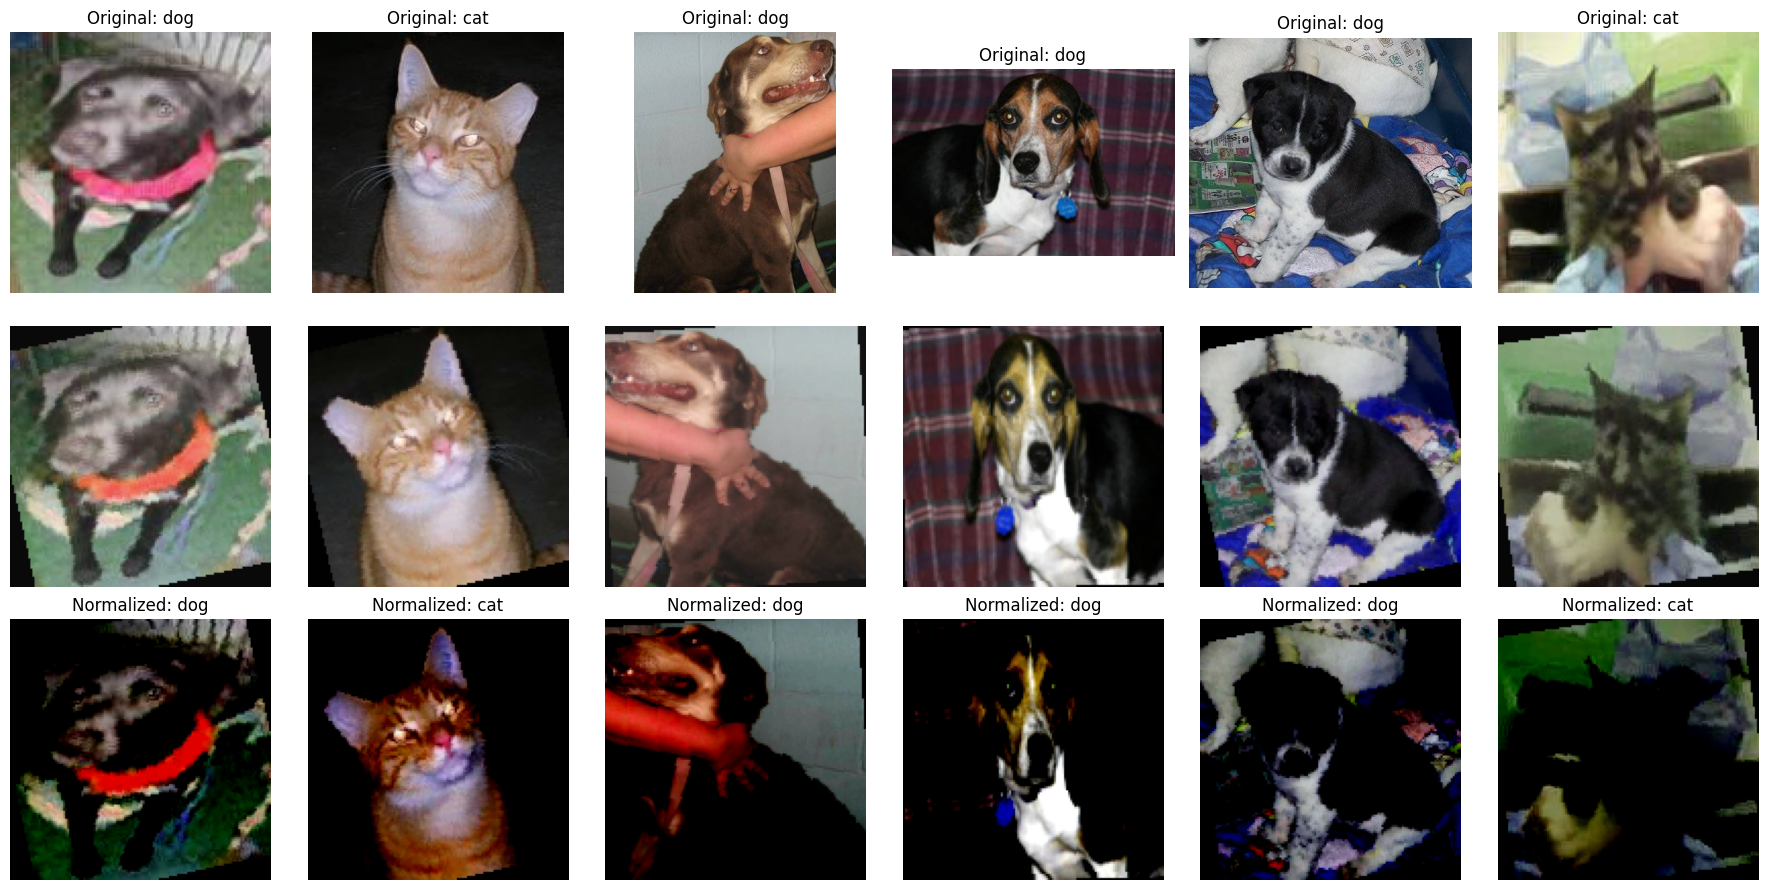

In [5]:
# Demonstrate Some Transformed Samples
# Display a few samples after transformations to verify the augmentation and normalization
# Function to unnormalize and display images
def imshow(img_tensor, title=None):
    img = img_tensor * 0.5 + 0.5  # Unnormalize
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# Randomly select 6 indices from the training dataset
sample_indices = random.sample(range(len(train_dataset)), 6)

# Show 6 random images: original, transformed, and normalized
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for i, idx in enumerate(sample_indices):
    # Get the transformed image, label, and image path from the dataset
    transformed_img_tensor, label, img_path = train_dataset[idx]
    
    # Load the original image
    original_img = Image.open(img_path).convert('RGB')
    axes[0, i].imshow(original_img)
    axes[0, i].set_title(f"Original: {'cat' if 'cat' in img_path else 'dog'}")
    axes[0, i].axis('off')
    
    # Transformed image (after augmentation and unnormalization)
    imshow(transformed_img_tensor.clone(), title=f"Transformed: {'cat' if label == 0 else 'dog'}")
    axes[1, i].imshow(np.transpose((transformed_img_tensor.clone().numpy() * 0.5 + 0.5), (1, 2, 0)))
    axes[1, i].axis('off')
    
    # Normalized image (without unnormalizing)
    axes[2, i].imshow(np.transpose(transformed_img_tensor.clone().numpy(), (1, 2, 0)))
    axes[2, i].set_title(f"Normalized: {'cat' if label == 0 else 'dog'}")
    axes[2, i].axis('off')

plt.tight_layout()
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/sample_transforms_B.png')
plt.show()
plt.close()  # Close the figure to free up memory

In [6]:
# Initialize Pre-trained Model
# Load a pre-trained VGG16 model and modify it for binary classification
weights = VGG16_Weights.DEFAULT
model = models.vgg16(weights=weights)
# model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False  # Freeze the feature extraction layers

# # Freeze all layers first
# for param in model.parameters():
#     param.requires_grad = False
#
# # Unfreeze the last 5 layers of the classifier
# for param in list(model.classifier.parameters())[-5:]:
#     param.requires_grad = True

# Modify the classifier to output 2 classes (cat and dog)
model.classifier[6] = nn.Linear(4096, 2)

# Move model to GPU if available
model = model.to(device)

In [7]:
# Loss and Optimizer Setup
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [8]:
# Training Loop
# Training loop with model checkpointing to prevent data loss in case of interruption
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, checkpoint_path='models/checkpoint_model_B.pth'):
    model.train()
    train_losses, val_losses = [], []
    val_accuracies, val_f1_scores, val_aucs = [], [], []  # Initialize the lists for metrics

    # Load checkpoint if available
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        val_accuracies = checkpoint.get('val_accuracies', [])
        val_f1_scores = checkpoint.get('val_f1_scores', [])
        val_aucs = checkpoint.get('val_aucs', [])
        print(f"Resuming training from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        running_loss = 0.0
        model.train()  # Ensure the model is in training mode
        for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average training loss
        train_losses.append(running_loss / len(train_loader))
        # Validate the model and calculate metrics
        val_loss, val_accuracy, val_f1, val_auc = validate_model(model, criterion, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        val_aucs.append(val_auc)

        # Print epoch details
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}, AUC: {val_auc:.4f}")

        # Save checkpoint after each epoch
        if not os.path.exists(os.path.dirname(checkpoint_path)):
            os.makedirs(os.path.dirname(checkpoint_path))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'val_f1_scores': val_f1_scores,
            'val_aucs': val_aucs
        }, checkpoint_path)

    return train_losses, val_losses, val_accuracies, val_f1_scores, val_aucs

In [9]:
# Validation Loop: Calculate additional metrics
def validate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels, _ in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collecting all labels and predictions for metrics calculation
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = 0.0  # Handle case where AUC can't be computed

    print(f"Validation Metrics - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")
    return val_loss / len(val_loader), accuracy, f1, auc

In [10]:
# Training the Model
# Train the model and save progress periodically
train_losses, val_losses, val_accuracies, val_f1_scores, val_aucs = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=50)

Validation: 100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


Validation Metrics - Accuracy: 0.9368, F1 Score: 0.9368, AUC: 0.9369
Epoch 1/50, Train Loss: 0.5796, Validation Loss: 0.1544, Accuracy: 0.9368, F1 Score: 0.9368, AUC: 0.9369


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


Validation Metrics - Accuracy: 0.9359, F1 Score: 0.9358, AUC: 0.9360
Epoch 2/50, Train Loss: 0.1734, Validation Loss: 0.1783, Accuracy: 0.9359, F1 Score: 0.9358, AUC: 0.9360


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9452, F1 Score: 0.9452, AUC: 0.9451
Epoch 3/50, Train Loss: 0.1760, Validation Loss: 0.1432, Accuracy: 0.9452, F1 Score: 0.9452, AUC: 0.9451


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9440, F1 Score: 0.9440, AUC: 0.9440
Epoch 4/50, Train Loss: 0.1597, Validation Loss: 0.1374, Accuracy: 0.9440, F1 Score: 0.9440, AUC: 0.9440


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9436, F1 Score: 0.9436, AUC: 0.9436
Epoch 5/50, Train Loss: 0.1518, Validation Loss: 0.1449, Accuracy: 0.9436, F1 Score: 0.9436, AUC: 0.9436


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9369, F1 Score: 0.9369, AUC: 0.9370
Epoch 6/50, Train Loss: 0.1454, Validation Loss: 0.1594, Accuracy: 0.9369, F1 Score: 0.9369, AUC: 0.9370


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


Validation Metrics - Accuracy: 0.9497, F1 Score: 0.9497, AUC: 0.9497
Epoch 7/50, Train Loss: 0.1517, Validation Loss: 0.1262, Accuracy: 0.9497, F1 Score: 0.9497, AUC: 0.9497


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9477, F1 Score: 0.9477, AUC: 0.9477
Epoch 8/50, Train Loss: 0.1548, Validation Loss: 0.1438, Accuracy: 0.9477, F1 Score: 0.9477, AUC: 0.9477


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9084, F1 Score: 0.9077, AUC: 0.9082
Epoch 9/50, Train Loss: 0.1456, Validation Loss: 0.2636, Accuracy: 0.9084, F1 Score: 0.9077, AUC: 0.9082


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


Validation Metrics - Accuracy: 0.9507, F1 Score: 0.9507, AUC: 0.9507
Epoch 10/50, Train Loss: 0.1609, Validation Loss: 0.1333, Accuracy: 0.9507, F1 Score: 0.9507, AUC: 0.9507


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9361, F1 Score: 0.9360, AUC: 0.9360
Epoch 11/50, Train Loss: 0.1623, Validation Loss: 0.1579, Accuracy: 0.9361, F1 Score: 0.9360, AUC: 0.9360


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9347, F1 Score: 0.9345, AUC: 0.9345
Epoch 12/50, Train Loss: 0.1492, Validation Loss: 0.1699, Accuracy: 0.9347, F1 Score: 0.9345, AUC: 0.9345


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9543, F1 Score: 0.9543, AUC: 0.9543
Epoch 13/50, Train Loss: 0.1397, Validation Loss: 0.1259, Accuracy: 0.9543, F1 Score: 0.9543, AUC: 0.9543


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


Validation Metrics - Accuracy: 0.9513, F1 Score: 0.9513, AUC: 0.9514
Epoch 14/50, Train Loss: 0.1307, Validation Loss: 0.1257, Accuracy: 0.9513, F1 Score: 0.9513, AUC: 0.9514


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


Validation Metrics - Accuracy: 0.9493, F1 Score: 0.9493, AUC: 0.9493
Epoch 15/50, Train Loss: 0.1299, Validation Loss: 0.1298, Accuracy: 0.9493, F1 Score: 0.9493, AUC: 0.9493


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


Validation Metrics - Accuracy: 0.9499, F1 Score: 0.9499, AUC: 0.9499
Epoch 16/50, Train Loss: 0.1289, Validation Loss: 0.1307, Accuracy: 0.9499, F1 Score: 0.9499, AUC: 0.9499


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


Validation Metrics - Accuracy: 0.9501, F1 Score: 0.9501, AUC: 0.9501
Epoch 17/50, Train Loss: 0.1183, Validation Loss: 0.1450, Accuracy: 0.9501, F1 Score: 0.9501, AUC: 0.9501


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


Validation Metrics - Accuracy: 0.9489, F1 Score: 0.9489, AUC: 0.9490
Epoch 18/50, Train Loss: 0.1235, Validation Loss: 0.1263, Accuracy: 0.9489, F1 Score: 0.9489, AUC: 0.9490


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9508, F1 Score: 0.9508, AUC: 0.9508
Epoch 19/50, Train Loss: 0.1279, Validation Loss: 0.1252, Accuracy: 0.9508, F1 Score: 0.9508, AUC: 0.9508


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9521, F1 Score: 0.9521, AUC: 0.9521
Epoch 20/50, Train Loss: 0.1228, Validation Loss: 0.1236, Accuracy: 0.9521, F1 Score: 0.9521, AUC: 0.9521


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


Validation Metrics - Accuracy: 0.9481, F1 Score: 0.9481, AUC: 0.9482
Epoch 21/50, Train Loss: 0.1162, Validation Loss: 0.1425, Accuracy: 0.9481, F1 Score: 0.9481, AUC: 0.9482


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


Validation Metrics - Accuracy: 0.9527, F1 Score: 0.9527, AUC: 0.9527
Epoch 22/50, Train Loss: 0.1187, Validation Loss: 0.1324, Accuracy: 0.9527, F1 Score: 0.9527, AUC: 0.9527


Validation: 100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


Validation Metrics - Accuracy: 0.9537, F1 Score: 0.9537, AUC: 0.9537
Epoch 23/50, Train Loss: 0.1103, Validation Loss: 0.1249, Accuracy: 0.9537, F1 Score: 0.9537, AUC: 0.9537


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9561, F1 Score: 0.9561, AUC: 0.9561
Epoch 24/50, Train Loss: 0.1117, Validation Loss: 0.1224, Accuracy: 0.9561, F1 Score: 0.9561, AUC: 0.9561


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9547, F1 Score: 0.9547, AUC: 0.9547
Epoch 25/50, Train Loss: 0.1125, Validation Loss: 0.1260, Accuracy: 0.9547, F1 Score: 0.9547, AUC: 0.9547


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9557, F1 Score: 0.9557, AUC: 0.9557
Epoch 26/50, Train Loss: 0.1093, Validation Loss: 0.1204, Accuracy: 0.9557, F1 Score: 0.9557, AUC: 0.9557


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


Validation Metrics - Accuracy: 0.9553, F1 Score: 0.9553, AUC: 0.9553
Epoch 27/50, Train Loss: 0.1070, Validation Loss: 0.1268, Accuracy: 0.9553, F1 Score: 0.9553, AUC: 0.9553


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9541, F1 Score: 0.9541, AUC: 0.9541
Epoch 28/50, Train Loss: 0.1071, Validation Loss: 0.1246, Accuracy: 0.9541, F1 Score: 0.9541, AUC: 0.9541


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9543, F1 Score: 0.9543, AUC: 0.9543
Epoch 29/50, Train Loss: 0.1051, Validation Loss: 0.1232, Accuracy: 0.9543, F1 Score: 0.9543, AUC: 0.9543


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9499, F1 Score: 0.9499, AUC: 0.9499
Epoch 30/50, Train Loss: 0.1014, Validation Loss: 0.1265, Accuracy: 0.9499, F1 Score: 0.9499, AUC: 0.9499


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9589, F1 Score: 0.9589, AUC: 0.9589
Epoch 31/50, Train Loss: 0.1102, Validation Loss: 0.1162, Accuracy: 0.9589, F1 Score: 0.9589, AUC: 0.9589


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9552, F1 Score: 0.9552, AUC: 0.9551
Epoch 32/50, Train Loss: 0.1075, Validation Loss: 0.1270, Accuracy: 0.9552, F1 Score: 0.9552, AUC: 0.9551


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9531, F1 Score: 0.9531, AUC: 0.9530
Epoch 33/50, Train Loss: 0.1018, Validation Loss: 0.1263, Accuracy: 0.9531, F1 Score: 0.9531, AUC: 0.9530


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9489, F1 Score: 0.9489, AUC: 0.9490
Epoch 34/50, Train Loss: 0.1025, Validation Loss: 0.1684, Accuracy: 0.9489, F1 Score: 0.9489, AUC: 0.9490


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9543, F1 Score: 0.9543, AUC: 0.9542
Epoch 35/50, Train Loss: 0.1026, Validation Loss: 0.1384, Accuracy: 0.9543, F1 Score: 0.9543, AUC: 0.9542


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9559, F1 Score: 0.9559, AUC: 0.9559
Epoch 36/50, Train Loss: 0.0991, Validation Loss: 0.1143, Accuracy: 0.9559, F1 Score: 0.9559, AUC: 0.9559


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9533, F1 Score: 0.9533, AUC: 0.9533
Epoch 37/50, Train Loss: 0.0962, Validation Loss: 0.1336, Accuracy: 0.9533, F1 Score: 0.9533, AUC: 0.9533


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9539, F1 Score: 0.9539, AUC: 0.9538
Epoch 38/50, Train Loss: 0.0963, Validation Loss: 0.1353, Accuracy: 0.9539, F1 Score: 0.9539, AUC: 0.9538


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9575, F1 Score: 0.9575, AUC: 0.9575
Epoch 39/50, Train Loss: 0.0933, Validation Loss: 0.1261, Accuracy: 0.9575, F1 Score: 0.9575, AUC: 0.9575


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


Validation Metrics - Accuracy: 0.9541, F1 Score: 0.9541, AUC: 0.9541
Epoch 40/50, Train Loss: 0.0948, Validation Loss: 0.1282, Accuracy: 0.9541, F1 Score: 0.9541, AUC: 0.9541


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


Validation Metrics - Accuracy: 0.9513, F1 Score: 0.9513, AUC: 0.9513
Epoch 41/50, Train Loss: 0.0905, Validation Loss: 0.1426, Accuracy: 0.9513, F1 Score: 0.9513, AUC: 0.9513


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9580, F1 Score: 0.9580, AUC: 0.9580
Epoch 42/50, Train Loss: 0.0918, Validation Loss: 0.1380, Accuracy: 0.9580, F1 Score: 0.9580, AUC: 0.9580


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9548, F1 Score: 0.9548, AUC: 0.9548
Epoch 43/50, Train Loss: 0.0970, Validation Loss: 0.1275, Accuracy: 0.9548, F1 Score: 0.9548, AUC: 0.9548


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9567, F1 Score: 0.9567, AUC: 0.9566
Epoch 44/50, Train Loss: 0.0901, Validation Loss: 0.1245, Accuracy: 0.9567, F1 Score: 0.9567, AUC: 0.9566


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9573, F1 Score: 0.9573, AUC: 0.9573
Epoch 45/50, Train Loss: 0.0901, Validation Loss: 0.1326, Accuracy: 0.9573, F1 Score: 0.9573, AUC: 0.9573


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9545, F1 Score: 0.9545, AUC: 0.9546
Epoch 46/50, Train Loss: 0.0944, Validation Loss: 0.1429, Accuracy: 0.9545, F1 Score: 0.9545, AUC: 0.9546


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9536, F1 Score: 0.9536, AUC: 0.9536
Epoch 47/50, Train Loss: 0.0918, Validation Loss: 0.1463, Accuracy: 0.9536, F1 Score: 0.9536, AUC: 0.9536


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


Validation Metrics - Accuracy: 0.9543, F1 Score: 0.9543, AUC: 0.9542
Epoch 48/50, Train Loss: 0.0859, Validation Loss: 0.1331, Accuracy: 0.9543, F1 Score: 0.9543, AUC: 0.9542


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Validation Metrics - Accuracy: 0.9557, F1 Score: 0.9557, AUC: 0.9558
Epoch 49/50, Train Loss: 0.0825, Validation Loss: 0.1456, Accuracy: 0.9557, F1 Score: 0.9557, AUC: 0.9558


Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9565, F1 Score: 0.9565, AUC: 0.9565
Epoch 50/50, Train Loss: 0.0861, Validation Loss: 0.1367, Accuracy: 0.9565, F1 Score: 0.9565, AUC: 0.9565


In [11]:
# Save the Final Model
# Save the final trained model
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/classifier_model_B.pth')

Validation: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Validation Metrics - Accuracy: 0.9568, F1 Score: 0.9568, AUC: 0.9568
Loaded Model - Validation Loss: 0.1361, Accuracy: 0.9568, F1 Score: 0.9568, AUC: 0.9568
Loss plot saved as training_validation_loss_B.png
Metrics plot saved as validation_metrics_B.png


<Figure size 1000x500 with 0 Axes>

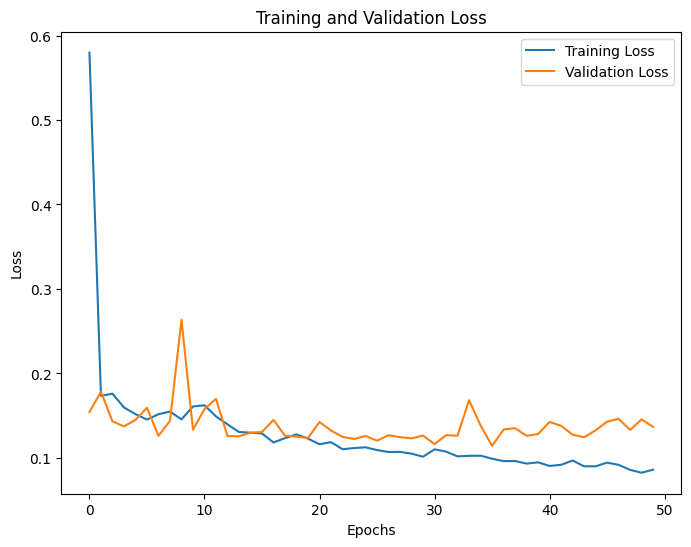

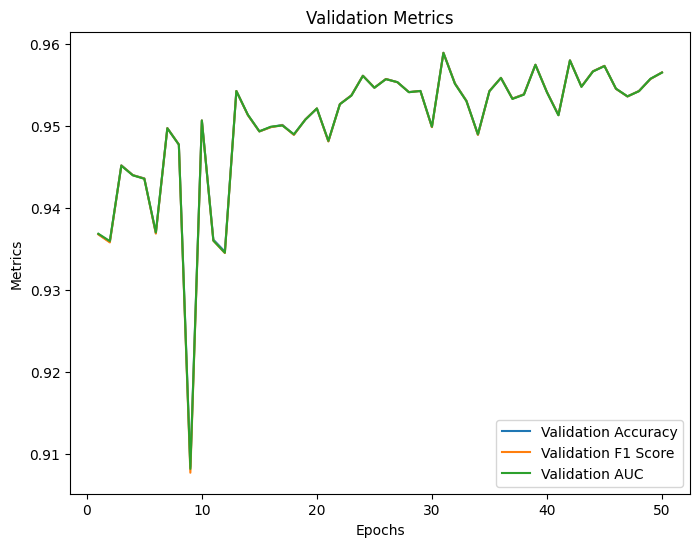

In [12]:
# Plotting Loss Curves
# Load model and evaluate metrics without retraining
checkpoint_path = 'models/checkpoint_model_B.pth'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=False)  # Load saved model
    model.load_state_dict(checkpoint['model_state_dict'])
    
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    val_accuracies = checkpoint.get('val_accuracies', [])
    val_f1_scores = checkpoint.get('val_f1_scores', [])
    val_aucs = checkpoint.get('val_aucs', [])

    # Evaluate the model using validation dataset
    val_loss, val_accuracy, val_f1, val_auc = validate_model(model, criterion, test_loader)
    print(f"Loaded Model - Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}, AUC: {val_auc:.4f}")
else:
    print("No saved model found.")

# Plotting Loss Curves and Metrics
if len(train_losses) > 0 and len(val_losses) > 0:
    plt.figure(figsize=(10, 5))
    
    # Plotting Loss
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig('figures/training_validation_loss_B.png')
    print('Loss plot saved as training_validation_loss_B.png')

    # Plotting Metrics: Accuracy, F1, AUC
    plt.figure(figsize=(8, 6))
    epochs = list(range(1, len(val_accuracies) + 1))
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
    plt.plot(epochs, val_aucs, label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.title('Validation Metrics')
    plt.savefig('figures/validation_metrics_B.png')
    print('Metrics plot saved as validation_metrics_B.png')
else:
    print("No loss data to plot.")

Confusion Matrix Calculation: 100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


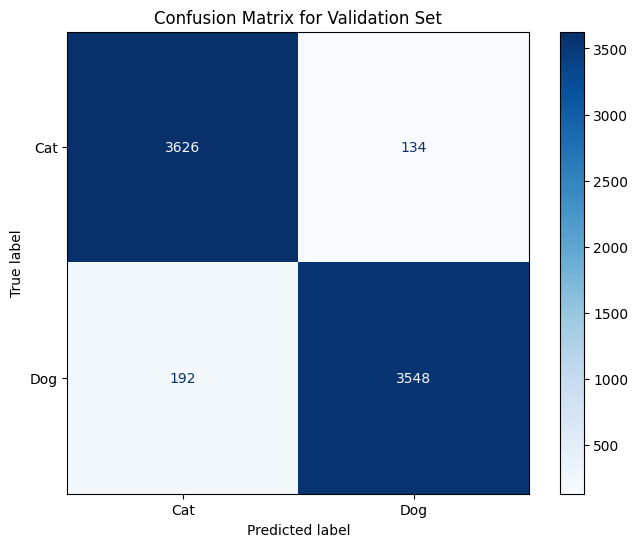

Confusion matrix saved as confusion_matrix_B.png


In [13]:
# Plot Confusion Matrix
# Function to plot and save confusion matrix
def plot_confusion_matrix(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels, _ in tqdm(val_loader, desc="Confusion Matrix Calculation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])

    # Plot and save confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title('Confusion Matrix for Validation Set')
    plt.savefig('figures/confusion_matrix_B.png')
    plt.show()
    plt.close()  # Close the figure to free up memory
    print('Confusion matrix saved as confusion_matrix_B.png')

# Call the function after testing
plot_confusion_matrix(model, test_loader)

Finding Incorrect Predictions: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


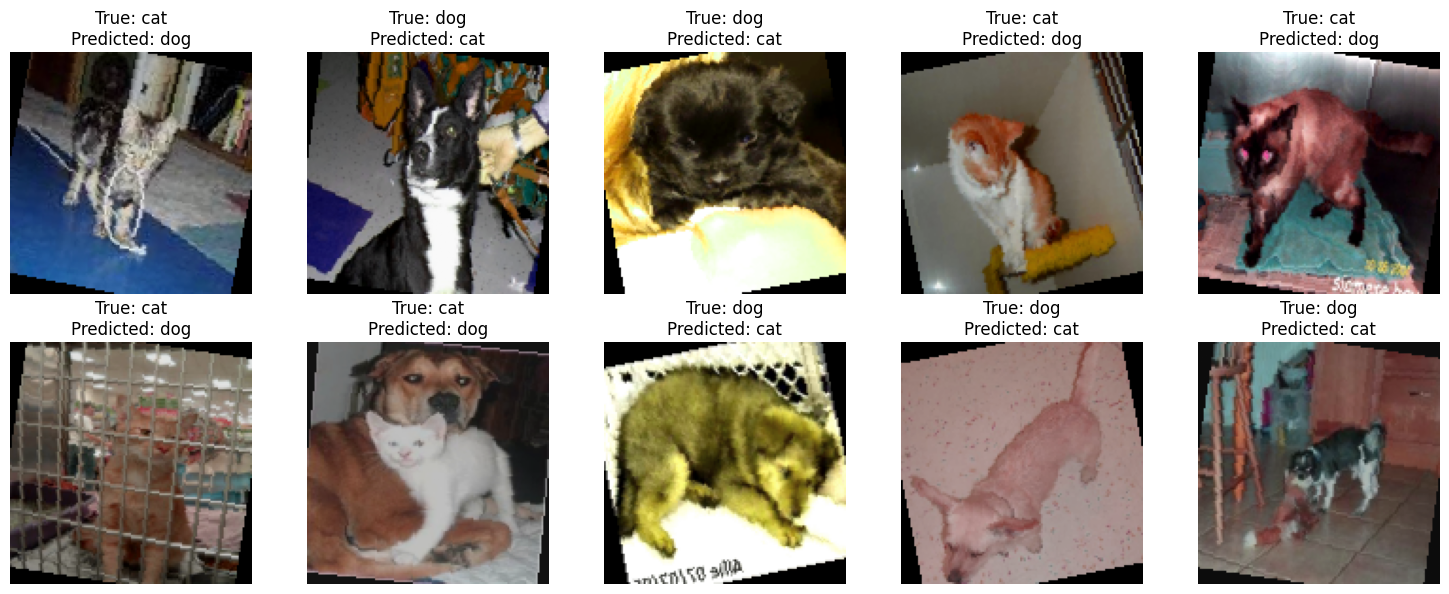

Incorrect predictions saved as incorrect_predictions_B.png


In [14]:
# Analyze Incorrect Predictions
# Function to plot incorrectly classified images to help understand model weaknesses
def plot_incorrect_predictions(model, val_loader, num_images=10):
    model.eval()
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for inputs, labels, _ in tqdm(val_loader, desc="Finding Incorrect Predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            incorrect_indices = (preds != labels).nonzero(as_tuple=True)[0]

            for idx in incorrect_indices:
                if len(incorrect_images) >= num_images:
                    break
                incorrect_images.append(inputs[idx].cpu())
                incorrect_labels.append(labels[idx].item())
                incorrect_preds.append(preds[idx].item())

    # Plotting incorrect predictions
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for i in range(len(incorrect_images)):
        image = incorrect_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5  # Reverse normalization
        image = np.clip(image, 0, 1)
        true_label = 'cat' if incorrect_labels[i] == 0 else 'dog'
        predicted_label = 'cat' if incorrect_preds[i] == 0 else 'dog'
        axes[i].imshow(image)
        axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.savefig('figures/incorrect_predictions_B.png')
    plt.show()
    plt.close()  # Close the figure to free up memory
    print('Incorrect predictions saved as incorrect_predictions_B.png')

# Call the function to visualize incorrect predictions
plot_incorrect_predictions(model, test_loader)

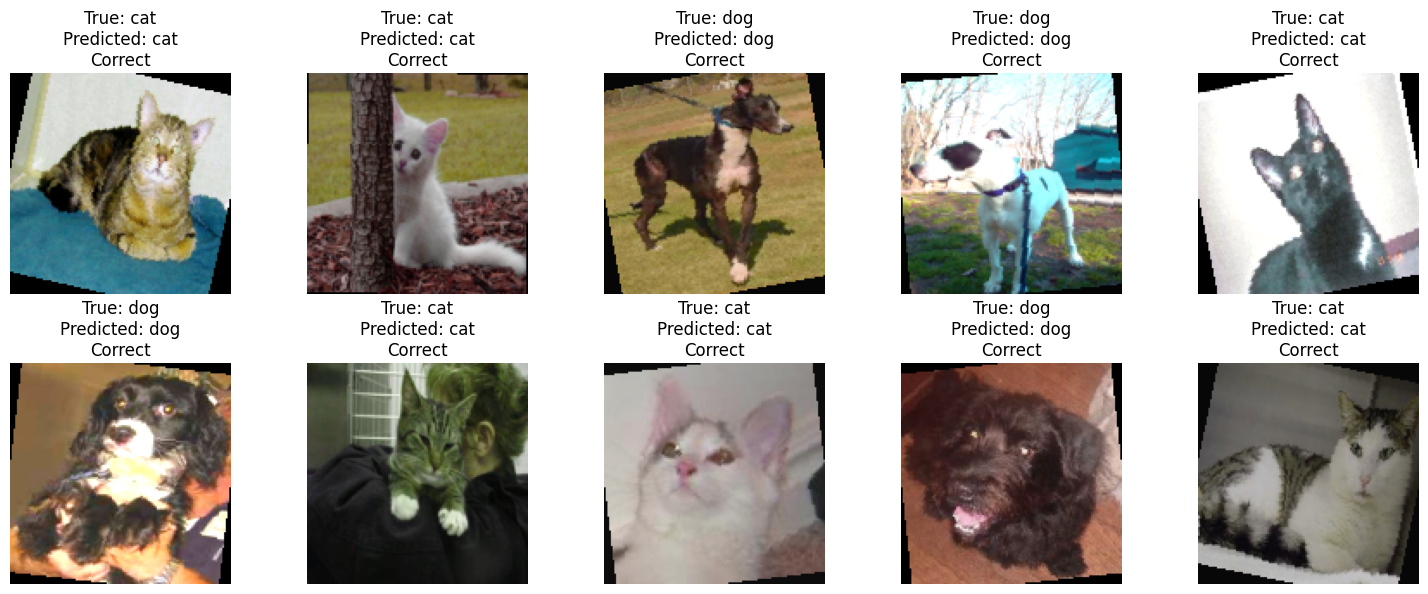

Correct Predictions: 10/10
Incorrect Predictions: 0/10


In [15]:
# Test the Model on Sample Images
# Evaluate the model's performance on randomly selected images from the validation set
def test_model_on_validation_samples(model, val_dataset, num_samples=10):
    model.eval()
    sample_indices = random.sample(range(len(val_dataset)), num_samples)
    correct_predictions = 0
    incorrect_predictions = 0
    results = []

    # Iterate over the selected images
    for idx in sample_indices:
        image, label, _ = val_dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = 'cat' if predicted.item() == 0 else 'dog'
            true_label = 'cat' if label == 0 else 'dog'
            success = (predicted_label == true_label)
            if success:
                correct_predictions += 1
            else:
                incorrect_predictions += 1
            results.append((image, true_label, predicted_label, success))

    # Plotting results in a matrix format
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for i, (image, true_label, predicted_label, success) in enumerate(results):
        image = image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Reverse normalization
        image = np.clip(image, 0, 1)
        axes[i].imshow(image)
        axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}\n{'Correct' if success else 'Incorrect'}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.savefig('figures/validation_predictions_B.png')
    plt.show()
    plt.close()  # Close the figure to free up memory

    # Summary of results
    print(f"Correct Predictions: {correct_predictions}/{num_samples}")
    print(f"Incorrect Predictions: {incorrect_predictions}/{num_samples}")

# Test the model on some sample validation images
test_model_on_validation_samples(model, val_dataset, num_samples=10)